In [1]:
import csv
import transformers
import numpy as np
from scipy.spatial.distance import cosine
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
#% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


c:\Users\henry\Desktop\MastersProject\QC_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BertEncoding():
	#https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX#scrollTo=Zn0n2S-FWZih
	"""
	Reads a CSV of format:
		word1 word2, word3 word4, label
	Where word1&2 make sentence 1 and 3&4 make sentence2.
	"""
	def __init__(self, csv_dir):
		self.data = self.listOfRowsFromSCV(csv_dir)
		self.model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True).eval()# output_hidden_states is whether the model returns all hidden-states. # Put the model in "evaluation" mode, meaning feed-forward operation. 
		pass

	def listOfRowsFromSCV(self, csv_dir):
		rows = []
		with open(csv_dir, "r") as csvfile:
			reader_variable = csv.reader(csvfile, delimiter=",")
			for row in reader_variable:
				rows.append(row)
		return rows	
	
	def getSentEmbedding(self, sent):
		marked_text = "[CLS] " + sent + " [SEP]"
		tokenized_text = tokenizer.tokenize(marked_text)	# Tokenize our sentence with the BERT tokenizer.
		return(tokenized_text)	# Print out the tokens.

	def preprocessSentence(self, sent, printing=None):
		# Add the special tokens.
		marked_text = "[CLS] " + sent + " [SEP]"
		# Split the sentence into tokens.
		tokenized_text = tokenizer.tokenize(marked_text)
		# Map the token strings to their vocabulary indeces.
		indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
		if printing:
			# Display the words with their indeces.
			for tup in zip(tokenized_text, indexed_tokens):
				print('{:<12} {:>6,}'.format(tup[0], tup[1]))

		# Mark each of the 22 tokens as belonging to sentence "1".
		segments_ids = [1] * len(tokenized_text)
		if printing:
			print(segments_ids)

		# Convert inputs to PyTorch tensors
		tokens_tensor = torch.tensor([indexed_tokens])
		segments_tensors = torch.tensor([segments_ids])
		return tokens_tensor, segments_tensors
	
	def hiddenLayersBERT(self, sentences):
		# Run the text through BERT, and collect all of the hidden states produced from all 12 layers. 
		hidden_states = [] 
		for idx, sentence in enumerate(sentences):
			with torch.no_grad():
				outputs = self.model(sentence[0], sentence[1])
				
				# Evaluating the model will return a different number of objects based on 
				# how it's  configured in the `from_pretrained` call earlier. In this case, 
				# becase we set `output_hidden_states = True`, the third item will be the 
				# hidden states from all layers. See the documentation for more details:
				# https://huggingface.co/transformers/model_doc/bert.html#bertmodel
				hidden_states.append(outputs[2])
		return hidden_states

	def GetTokenVecSum(self, hidden_state):
		# Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
		# Remove dimension 1, the "batches".
		# Swap dimensions 0 and 1.
		token_embeddings = torch.squeeze(torch.stack(hidden_state, dim=0), dim=1).permute(1,0,2)

		# `hidden_state` has shape [13 x 1 x 22 x 768]
		# `token_vecs` is a tensor with shape [22 x 768]
		token_vecs = hidden_state[-2][0]

		# Calculate the average of all 22 token vectors.
		sentence_embedding = torch.mean(token_vecs, dim=0)

		#stores the token vectors, with shape [22 x 768]
		token_vecs_sum = []

		# `token_embeddings` is a [22 x 12 x 768] tensor.
		for token in token_embeddings:
			# `token` is a [12 x 768] tensor
			# Sum the vectors from the last four layers.
			sum_vec = torch.sum(token[-4:], dim=0)
			# Use `sum_vec` to represent `token`.
			token_vecs_sum.append(sum_vec)

		#print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))
		return token_vecs_sum, sentence_embedding

	def BERTSentances(self, row_number):
		sents_to_evaluate = [self.preprocessSentence(self.data[row_number][0]), self.preprocessSentence(self.data[row_number][1])]

		hidden = self.hiddenLayersBERT(sents_to_evaluate)
		return hidden

	def GetEmbeddingsForBothSentences(self, sentences):
		token_embedding_list = []
		sentence_embedding_list = []
		for idx, sentence in enumerate(sentences):
			token_embedding_list.append(self.GetTokenVecSum(sentence)[0])
			sentence_embedding_list.append(self.GetTokenVecSum(sentence)[1])
		return token_embedding_list, sentence_embedding_list
	
	def CosineSimilarity(self, sent0, sent1):
		return 1-cosine(sent0, sent1)
	
	def evaluateSentPair(self, row_number):
		sents_to_evaluate = [self.preprocessSentence(self.data[row_number][0]), self.preprocessSentence(self.data[row_number][1])]

		hidden = self.hiddenLayersBERT(sents_to_evaluate)
		embeddings = self.GetEmbeddingsForBothSentences(hidden)

		return self.CosineSimilarity(embeddings[1][0], embeddings[1][1])
	
	def evaluateAllSentPairs(self):
		res = []
		for i in range(len(self.data)):
			res.append(self.evaluateSentPair(i))
		return res

# Plot Classical Similarities

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


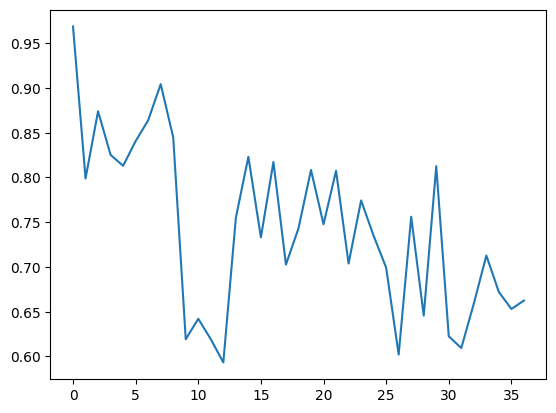

In [3]:
bertWwords = BertEncoding("DataSet.csv")
similarities = bertWwords.evaluateAllSentPairs()
plt.plot(similarities)

# Output Vectors to work with:

These are a (2,13) array such that the column [0] of length 13 is made from 13 tensors of shape (1,4,768)

In [4]:
np.shape(bertWwords.BERTSentances(2)), np.shape(bertWwords.BERTSentances(2)[0]), np.shape(bertWwords.BERTSentances(2)[0][0])

c:\Users\henry\Desktop\MastersProject\QC_env\lib\site-packages\numpy\core\fromnumeric.py:2009: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
c:\Users\henry\Desktop\MastersProject\QC_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


((2, 13), (13,), torch.Size([1, 4, 768]))

In [11]:
word_vec = np.ravel(bertWwords.BERTSentances(2)[0][0]) #Possibly use alternative to ravel
len(word_vec)

3072

# Autoencoder to resize vectors 3072(768x4) -> 15

In [6]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [15]:
encoding_dim = 15 
input_img = Input(shape=(3072,))
# encoded representation of input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# decoded representation of code 
decoded1 = Dense(3072, activation='sigmoid')(encoded)
decoded2 = Dense(784, activation='sigmoid')(encoded)
# Model which take input image and shows decoded images
autoencoder = Model(input_img, [decoded1, decoded2])

# This model shows encoded images
encoder = Model(input_img, encoded)
# Creating a decoder model
encoded_input = Input(shape=(encoding_dim,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)
